In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\ERM_GDRO


# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

## Defining functions & parameters

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# .csv to load results from
load_path = 'test_results/mnist_new/accuracies.csv'

In [44]:
def plot_acc(drop_epochs=[], err_margin=0):
    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["trial", "epoch", "subtype"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))
    
    trial_means = results_df.stack().unstack(level=0).mean(axis=1).unstack(level=2)
    trial_errs = results_df.stack().unstack(level=0).std(axis=1).unstack(level=2) / (N ** 0.5)

    trial_means.drop(drop_epochs, level=0, axis=0, inplace=True)
    hide = []
    
    subtypes = ["Overall", "8"]

    f, a = plt.subplots(1, 2)

    # plot subtypes sensitivity

    for i in range(len(subtypes)):
        plot_data = trial_means.drop(columns=hide).xs(subtypes[i], level=1)
        plot_data.plot(ylim=[0.5,1],xlabel="Epoch",ylabel="Accuracy",kind='line',title=subtypes[i],ax=a[i],figsize=(12, 6),grid=True)
        plot_errs = trial_errs.drop(columns=hide).xs(key=subtypes[i], level=1)
        for col in plot_data.columns:
            a[i].fill_between(list(plot_data.index), plot_data[col] + err_margin * plot_errs[col], plot_data[col] - err_margin * plot_errs[col], alpha=0.25)
        

In [45]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind

def ttest(p_threshold=0.05):
    print(f't-tests with significance threshold p<{p_threshold}\n')
    ttest_dataframes = {}

    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

    for s in range(len(subtypes)):
        epoch = epochs - 1

        subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
        erm_data = subtype_data["ERMLoss"].values

        print(subtypes[s])
        for algorithm in results_df.columns:
            if algorithm != "ERMLoss":
                algorithm_data = subtype_data[algorithm].values
                stat, p = ttest_ind(algorithm_data, erm_data)

                print(f'ERMLoss: {erm_data.mean():.3f}, 1.96*stdErr: {(1.96 * erm_data.std(ddof=1) / (len(erm_data) ** 0.5)):.2e}')
                print(f'{algorithm}: {algorithm_data.mean():.3f}, 1.96*stdErr: {(1.96 * algorithm_data.std(ddof=1) / (len(algorithm_data) ** 0.5)):.2e}')
                if p < p_threshold:
                    print(f'{algorithm if stat > 0 else "ERMLoss"} greater with p = {p:.2e}')
                else:
                    print(f'No significant difference with p = {p:.2e}')
                print()

## Show results

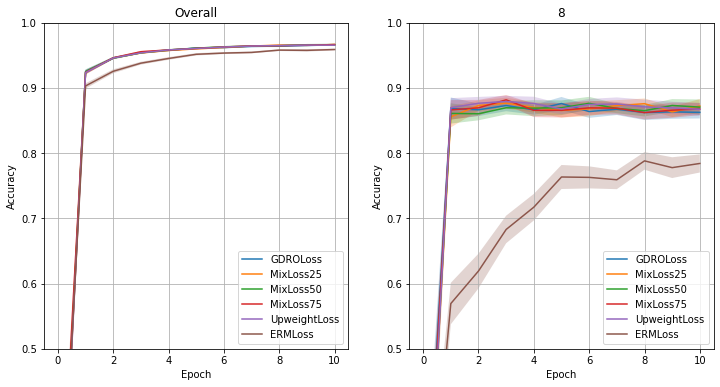

In [46]:
plot_acc(err_margin=1.96)

In [ ]:
ttest(p_threshold=0.05)